Here we implement the solver from [Quantum algorithm for solving linear differential equations: Theory and experiment](https://journals.aps.org/pra/pdf/10.1103/PhysRevA.101.032307) by Xin *et al.* in the **Classiq** quantum programming language. 

### Classical Problem

Xin *et al.* provide a new method to solve any Linear Differential Equation formulated as 

$$\frac{d}{dt}\vec{x}(t)= M\vec{x}(t)+\vec{b}$$

for an $N\times N$ matrix $M$ and $N$-dimensional vectors $x$, $b$. 

Taylor-expanding the analytical solution, 

$$
\begin{aligned}
x(t)&=e^{Mt}x(0)+\left(e^{Mt}-\mathbb{I}\right)M^{-1}b
\\
&\approx \sum^k_{m=0}\frac{(Mt)^m}{m!}x(0)+\sum^k_{n=1}\frac{M^{n-1}t^n}{n!}b.
\end{aligned}
$$

### Quantum Formulation

1. Prepare two quantum states $\ket{x(0)}$ and $\ket{b}$ in the $N$-dimensional computational basis, on $\log_2(N)$ qubits. 
1. Describe the $N\times N$ operator $M$ as $A$ in the computational basis, such that $A_{ij}=M_{ij}\ket{i}\bra{j}$ up to normalization.

We then arrive at 

$$\ket{x(t)}\approx \sum_{m=0}^k \frac{\|x(0)\|(\|M\|At)^m}{m!}\ket{x(0)}+\sum_{n=1}^k\frac{\|b\|(\|M\|A)^{n-1}t^n}{n!}\ket{b}$$


#### More Encodings
1. Assuming $A$ is unitary, encode $k$ powers of $A$ as the unitaries $U_n=A^n$.
1. Define $C_m=\|x(0)\|(\|M\|t)^m/m!$ and $D_n=\|b\|(\|M\|t)^{n-1}t/n!$



### Using Classiq

You need to install the `classiq` Python module from `pip` beforehand. You can do this with Anaconda via the provided `.yml` file with the terminal line `conda env create -f environment.yml`. 

You then need to authenticate the module by running the following code block once, which will pop up a login window in your browser. 

In [ ]:
# ONLY RUN THIS ONCE TO AUTHENTICATE DEVICE
import classiq
classiq.authenticate(overwrite=True)

First, we import all relevant modules and Classiq functions, as well as handy utility functions we wrote in `util.py`.

In [22]:
import numpy as np
np.set_printoptions(precision=3)
import scipy.linalg as la
import math
import time, os
from tqdm import tqdm

from classiq import (
    qfunc, Output, QBit, QNum, QArray, CInt,
    allocate, within_apply, control, repeat, if_, 
    #inplace_prepare_state, hadamard_transform, inplace_prepare_int, 
    inplace_prepare_amplitudes,
    create_model, write_qmod,
    X, H, SWAP, IDENTITY,
    unitary,
    Constraints, Preferences, 
)
from classiq.synthesis import synthesize, set_constraints, set_execution_preferences, set_preferences, show
from classiq.executor import execute
from classiq.execution import ExecutionPreferences, IBMBackendPreferences,  IBMBackendProvider
from classiq.interface.generator.quantum_program import QuantumProgram

from util import quantum_encode, is_unitary, write_qprog, parse_classiq_result, quantum_vectorize

# wierd bug with asyncio and jupyter notebooks...
import nest_asyncio
nest_asyncio.apply()

To submit the code to Classiq and process it, we wrap all of the native `qfunc`s with a larger function that allows us to vary the order of the Taylor approximation $k$, the time $t$, and the error bound of the amplitude encoding.

In [37]:
class QuantumLDESolver():
    """
    Class of quantum algorithms implemented from "Quantum algorithm for solving 
     linear differential equations: Theory and experiment" by Xin et. al. (2020) 
     at https://journals.aps.org/pra/pdf/10.1103/PhysRevA.101.032307

     TODO: implement non-unitary M solving
    """

    def __init__(self, M, x0, b, k=2, err_bound=0.1, 
                 print_info=True):
        """ Initialize a single LDE problem of dx/dt = Mx + b
        Inputs:
         -  M: matrix of the LDE
         - x0: initial condition vector
         -  b: forcing vector
         -  k: order of Taylor expansion
         - err_bound: error bound for Classiq's coefficient approximation
        """
        self.k = k
        self.err_bound = err_bound
        self.cwd = os.getcwd()
        self.data = None

        self.x0 = quantum_encode(x0)
        self.b  = quantum_encode(b)
        if len(x0) != len(b):
            raise ValueError("x0 and b must be the same length")
        self.M = np.array(M)
        if len(x0) < len(M[0]):
            raise ValueError("M is too big for given x0, b")
        if len(x0) != len(M[0]):
            # extend M to larger hilbert space of x0
            newM = np.identity((len(x0)))
            newM[:len(M[0]),:len(M[0])] = M
            self.M = newM
        
        # compute all norms once
        self.x0_norm = np.linalg.norm(x0)
        self.b_norm = np.linalg.norm(b)
        # use order-2 norm to preserve unitarity
        self.M_norm = np.linalg.norm(M, ord=2)
        A = M / self.M_norm
        self.isUnitary = is_unitary(A)
        if not self.isUnitary:
            raise NotImplementedError("Non-unitary M not yet implemented")
        self.U = [np.linalg.matrix_power(A, i).tolist() for i in range(0,k+1)]
        nqubits = math.ceil(math.log2(len(x0))) + math.ceil(math.log2(self.k+1))

        nqubits += 1 if self.b_norm != 0 else 0
        print(f'Needs at least {nqubits} qubits to run!')
        if print_info:
            print(f"Initialized LDE solver with k={k}, err_bound={err_bound}")
            print(f"Initial condition x0={x0} with norm {self.x0_norm}")
            print(f"Matrix M={M} with norm {self.M_norm}")
            print(f"Forcing vector b={b} with norm {self.b_norm}")
            print(f"Matrix A={A} is {'unitary' if self.isUnitary else 'not unitary'}")
    #
    # HELPER FUNCTIONS
    #
    def get_Cs_and_Ds(self, M_norm, x0_norm, b_norm, k, t):
        ''' returns (C_norm, D_norm, C_amps, D_amps) when b is nonzero '''
        C, D = np.empty(k+1), np.empty(k+1)
        coeff = 1
        for i in range(k+1):
            # D[0] = 0, reuse last coefficient
            if i != 0:
                D[i-1] = b_norm * coeff * t / i
                coeff *= M_norm * t / i
            C[i] = x0_norm * coeff
        
        Cnorm, C_amps = quantum_vectorize(C)
        Dnorm, D_amps = quantum_vectorize(D)
        return Cnorm, Dnorm, C_amps.tolist(), D_amps.tolist()
    
    def get_Cs(self, M_norm, x0_norm, k, t):
        ''' returns (C_norm, C_amps) when b is zero '''
        C = np.empty(k+1)
        C[0] = x0_norm
        for i in range(1,k+1):
            C[i] = C[i-1] * M_norm * t / i
        # encode amplitudes as probabilities
        Cnorm, C_amps = quantum_vectorize(C)
        return Cnorm, C_amps.tolist()
    
    def inp_multi_reg_amps(self, *args):
        """ prepare multiple QArray amplitudes at once
        Inputs: register1, amps1, register2, amps2, ... registerN, ampsN
        """
        for i in range(0, len(args), 2):
            inplace_prepare_amplitudes(amplitudes=args[i+1], 
                                       target=args[i], bound=self.err_bound)
    #
    # QUANTUM ALGORITHMS in CLASSIQ
    #
    def LDE_no_time_qmod(self, x0, k=2, save_qmod='', measure_x=False):
        """
        t = 0 case, trivially return x0, still in qmod for consistent output
        """
        @qfunc
        def main(work: Output[QArray], taylor: Output[QNum]):
            # allocate all qubits before doing anything
            allocate(math.ceil(math.log2(len(x0))), work)
            allocate(math.ceil(math.log2(k+1)), taylor)
            # encode x0
            self.inp_multi_reg_amps(work, x0)
            # measure in x-basis to recover sign difference?
            if_(condition=measure_x==True,
                then=lambda:  H(work[0]),
                else_=lambda: IDENTITY(work[0]))
        
        # create the model!
        qmod = create_model(main)
        # store the .qmod code!
        if save_qmod:
            write_qmod(qmod, save_qmod)
        return qmod

    def unitary_LDE_nob_qmod(self, x0, U, C_amps, k=2, save_qmod=''):
        """ 
        M is unitary AND b = 0 
        """
        @qfunc
        def prepare_registers(work: QArray, taylor: QNum):
            # evolve ancilla into superposition state
            # encode x_0 and Cvals into registers with |0> ancilla
            self.inp_multi_reg_amps(work, x0, taylor, C_amps)

        @qfunc
        def do_entangling(work: QArray, taylor: QNum):
            # apply powers of A to taylor register
            for i in range(k+1):
                control(taylor == i,
                        lambda: unitary(U[i], work))

        @qfunc
        def main(work: Output[QArray], taylor: Output[QNum]):
            # allocate all qubits before doing anything
            allocate(math.ceil(math.log2(len(x0))), work)
            allocate(math.ceil(math.log2(k+1)), taylor)
            # apply V^dag U V
            within_apply(lambda: prepare_registers(work, taylor),
                         lambda: do_entangling(work, taylor))
            # measure x on first qubit to get sign difference
            #if_(condition=measure_x==True, 
            #    then=lambda:  H(work),
            #    else_=lambda: IDENTITY(work))
        
        # create the model!
        qmod = create_model(main)
        # store the .qmod code!
        if save_qmod:
            write_qmod(qmod, save_qmod)
        return qmod
    
    def unitary_LDE_qmod(self, x0, b, U, CD_amp, C_amps, D_amps, k=2,
                         measure_x=False,save_qmod=''):
        """ 
        M is unitary AND b != 0
        """
        @qfunc
        def prepare_registers(x0_b_ancilla: QBit, work: QArray, taylor: QNum):
            # evolve ancilla into superposition state
            self.inp_multi_reg_amps(x0_b_ancilla, CD_amp)
            # encode x_0 and Cvals into registers with |0> ancilla
            control(x0_b_ancilla == 0, 
                    lambda: self.inp_multi_reg_amps(work, x0, taylor, C_amps))
            # encode b and Dvals into registers with |1> ancilla
            control(x0_b_ancilla == 1, 
                    lambda: self.inp_multi_reg_amps(work, b, taylor, D_amps))

        @qfunc
        def do_entangling(work: QArray, taylor: QNum):
            # apply powers of A to taylor register
            for i in range(k+1):
                control(taylor == i, 
                        lambda: unitary(U[i], work))

        @qfunc
        def main(x0_b_ancilla: Output[QBit], work: Output[QArray], 
                taylor: Output[QNum]):
            # allocate all qubits before doing anything
            allocate(1, x0_b_ancilla)
            allocate(math.ceil(math.log2(len(x0))), work)
            allocate(math.ceil(math.log2(k+1)), taylor)
            # apply V^dag U V
            within_apply(lambda: prepare_registers(x0_b_ancilla, work, taylor),
                         lambda: do_entangling(work, taylor))
            # measure x on first qubit to get sign difference
            if_(condition=measure_x==True, 
                then=lambda:  H(work[0]),
                else_=lambda: IDENTITY(work[0]))
        
        # create the model!
        qmod = create_model(main)
        # store the .qmod code!
        if save_qmod:
            write_qmod(qmod, save_qmod)
        return qmod
    
    def nonunitary_LDE_qmod(self, x0, b, U, CD_amp, C_amps, D_amps, k=2):
        """
        M is non-unitary and b != 0
        """
        return NotImplementedError("Non-unitary M not yet implemented")
    
    def nonunitary_LDE_nob_qmod(self, x0, b, U, C_amps, k=2):
        """
        M is non-unitary and b = 0
        """
        return NotImplementedError("Non-unitary M with zero b yet implemented")
    #
    # CLASSIQ EXECUTION
    #
    def run_qmod(self, qmod, opt='depth', nshots=10000, job_name='',
                 save_qprog='', sim='Classiq',
                 open_circuit=False, print_info=False):
        """ optimize qmod with constraints and run it on a simulator 
         - sim = 'Classiq' or 'IBM', both classical simulators though
        """
        # set constraints and preferences
        if sim == 'Classiq':
            max_width = 25
            qmod = set_preferences(qmod,
                Preferences(backend_service_provider="Classiq",backend_name="simulator"))
        elif sim == 'IBM':
            # REPLACE WITH YOUR OWN IBM API TOKEN!!
            token = '0920786a03ff0a185aca85f5c4a4be13232efe6641aa5685381a1c3984ec1ed1a7fdd85fbf1967af41bebbf30f321eadb4fb7188eb830a91100133a65e9a9fb1'
            max_width = 127
            qmod = set_preferences(qmod,
                IBMBackendPreferences(
                    backend_name="ibm_strasbourg",
                    access_token=token,
                    provider=IBMBackendProvider(hub = "ibm-q", 
                                                group = "open", project = "main")
                )
            )
        
        qmod = set_constraints(qmod,
            Constraints(max_width=max_width, optimization_parameter=opt))
        qmod = set_execution_preferences(qmod,
            ExecutionPreferences(num_shots=int(nshots), job_name=job_name, 
                                random_seed='767'))
        qmod = set_preferences(qmod,
            Preferences(timeout_seconds=600, optimization_timeout_seconds=120))
    
        # synthesize the circuit
        start_time = time.time()
        if print_info:
            print(f"Running {job_name}")
        qprog = synthesize(qmod)
        QP = QuantumProgram.from_qprog(qprog)
        circuit_width = QP.data.width
        circuit_depth = QP.transpiled_circuit.depth
        end_time = time.time()
        if print_info:
            print(f"\tcircuit synthesized in {end_time-start_time:.2f}s: width={circuit_width},depth={circuit_depth}")
        # open in viewer
        if open_circuit: 
            show(qprog)
        # save generated quantum program
        if save_qprog:
            write_qprog(qprog, save_qprog)
        start_time = time.time()
        
        job = execute(qprog)
        if print_info:
            print(
                f"\tjob with {job.num_shots} shots is {job.status} on provider-backend={job.provider}-{job.backend_name} \n\tand can be accessed at {job.ide_url}"
            )
        results = job.result()[0].value
        end_time = time.time()
        if print_info:
            print(f"\tran in {end_time-start_time:.2f}s")
        return results
    #
    # SOLVING THE WHOLE THING
    #
    def parse_classiq_result(self, N, rdict, print_info=True):
        from util import get_work_strings
        print(N, rdict)
        total_counts = rdict.num_shots
        # reconstruct / parse state vector
        out_map = rdict.output_qubits_map   
        vec_indices = out_map['work']         # tuple of indices
        print('vi:',vec_indices)
        nbits = 2**len(vec_indices)
        y = np.zeros(nbits)
        lsb_right = rdict.counts_lsb_right  # whether output map starts from right or left of string
        counts_dict = rdict.counts
        # set all other qubits to be 0, then reconstruct state vector from counts
        nqubits = len(list(counts_dict.keys())[0])
        # only care about all ancillas being zero
        work_strings = get_work_strings(nqubits, vec_indices, lsb_right)
        # iterate from least-significant to most-significant bitstring
        for j, work_string in enumerate(work_strings):
            if print_info:
                print(f'parsing |{work_string}> as x[{j}]')
            if work_string not in counts_dict:
                print(f"Work string {work_string} not found in counts!")
                continue
            # convert to probabilities = amp^2
            y[j] = counts_dict[work_string] / total_counts
        # convert to amplitudes and multiply by total normalization
        y = np.sqrt(y) * N**2
        return y

    def solve(self, times: list[float], opt='depth', nshots=1000, sim='Classiq', 
              open_circuit=False, print_info=True,
              k = None, err_bound = None):
        # allow rewriting of k and err_bound
        if k is not None:
            self.k = k
        if err_bound is not None:
            self.err_bound = err_bound

        # write directory
        dirpath = f"{self.cwd}/runs/k={self.k}/err_bound={err_bound}"
        if not os.path.isdir(dirpath):
            os.makedirs(dirpath+'/qmod')
            os.makedirs(dirpath+'/qprog')
        
        yt = np.zeros((len(times),len(self.x0)))
        with tqdm(total=len(times)) as pbar:
            for idx, t in enumerate(times):
                # name file
                name = 'LDE'
                if self.isUnitary: name += "_U"
                if self.b_norm == 0: name += '_no-b'
                name += f'_t={round(t,3)}'
                # generate .qmod file 
                if t == 0:
                    qmod = self.LDE_no_time_qmod(self.x0, self.k, save_qmod=f'{dirpath}/qmod/{name}')
                    N = np.sqrt(self.x0_norm)
                elif self.isUnitary:
                    if self.b_norm == 0:
                        N, C_amps = self.get_Cs(self.M_norm, self.x0_norm, self.k, t)
                        qmod = self.unitary_LDE_nob_qmod(self.x0, self.U, C_amps, self.k, save_qmod=f'{dirpath}/qmod/{name}')
                    else:
                        C, D, C_amps, D_amps = self.get_Cs_and_Ds(self.M_norm, self.x0_norm, self.b_norm, self.k, t)
                        N = np.sqrt(C**2 + D**2)
                        CD_amp = [C/N,D/N]
                        qmod = self.unitary_LDE_qmod(self.x0, self.b, self.U, CD_amp, C_amps, D_amps, self.k, save_qmod=f'{dirpath}/qmod/{name}')
                else:
                    return NotImplementedError("Non-unitary M not yet implemented")
                
                # run the quantum circuit on backend
                ret = self.run_qmod(qmod, opt, nshots, name, f'{dirpath}/qprog/{name}', sim, open_circuit, print_info=False)
                yt[idx] = self.parse_classiq_result(N,ret)
                pbar.update(1)
        self.data = yt
        return yt

    def solve_with_sign(self, times: list[float], opt='depth', nshots=1000, sim='Classiq', 
              open_circuit=False, print_info=True,
              k = None, err_bound = None):
        """
        Also bundle up sign information in output data, encoded 
        as (N, ret, sign) where sign is +1 or -1
        TODO: general sign processing
        """
        # allow rewriting of k and err_bound
        if k is not None:
            self.k = k
        if err_bound is not None:
            self.err_bound = err_bound

        # write directory
        dirpath = f"{self.cwd}/runs/k={self.k}/err_bound={err_bound}"
        if not os.path.isdir(dirpath):
            os.makedirs(dirpath+'/qmod')
            os.makedirs(dirpath+'/qprog')
        
        yt = np.zeros((len(times),len(self.x0)))
        with tqdm(total=len(times)*2) as pbar:
            for idx, t in enumerate(times):
                # name file
                name = 'LDE'
                if self.isUnitary: name += "_U"
                if self.b_norm == 0: name += '_no-b'
                name += f'_t={round(t,3)}'
                # generate .qmod file 
                if t == 0:
                    qmod = self.LDE_no_time_qmod(self.x0, self.k, save_qmod=f'{dirpath}/qmod/{name}')
                    qmod_x = self.LDE_no_time_qmod(self.x0, self.k, save_qmod=f'{dirpath}/qmod/{name}_x', measure_x=True)
                    N = np.sqrt(self.x0_norm)
                elif self.isUnitary:
                    if self.b_norm == 0:
                        N, C_amps = self.get_Cs(self.M_norm, self.x0_norm, self.k, t)
                        qmod_x = self.unitary_LDE_nob_qmod(self.x0, self.U, C_amps, self.k, save_qmod=f'{dirpath}/qmod/{name}_x', measure_x=True)
                        qmod = self.unitary_LDE_nob_qmod(self.x0, self.U, C_amps, self.k, save_qmod=f'{dirpath}/qmod/{name}')
                    else:
                        C, D, C_amps, D_amps = self.get_Cs_and_Ds(self.M_norm, self.x0_norm, self.b_norm, self.k, t)
                        N = np.sqrt(C**2 + D**2)
                        CD_amp = [C/N,D/N]
                        qmod = self.unitary_LDE_qmod(self.x0, self.b, self.U, CD_amp, C_amps, D_amps, self.k, save_qmod=f'{dirpath}/qmod/{name}')
                        qmod_x = self.unitary_LDE_qmod(self.x0, self.b, self.U, CD_amp, C_amps, D_amps, self.k, save_qmod=f'{dirpath}/qmod/{name}_x', measure_x=True)
                else:
                    return NotImplementedError("Non-unitary M not yet implemented")
                
                # run the quantum circuit on backend
                ret = self.run_qmod(qmod, opt, nshots, name, f'{dirpath}/qprog/{name}', sim, open_circuit, print_info=False)
                y = self.parse_classiq_result(N,ret)
                pbar.update(1)

                ret_x = self.run_qmod(qmod_x, opt, nshots, name+'_x', f'{dirpath}/qprog/{name}_x', sim, open_circuit, print_info=False)
                y_x = self.parse_classiq_result(N,ret_x)
                pbar.update(1)
                yt[idx] = y
                # assume first bit is zero, flip second bit
                if y_x[1] > y_x[0]:
                    yt[idx,1] *= -1
                if print_info:
                    print('Z:',y,'X:',y_x)
        self.data = yt
        return yt


### Our Problem
We solve the following differential equation:
$$\frac{d^2y(t)}{dt^2}=y''(t)=-\omega^2 y'(t),\quad y(0)=y'(0)=1\,.$$

We can linearize this in the form $\frac{d}{dt}\mathbf{x} = M\mathbf{x}+\mathbf{b}$ using $x=[y(t),y'(t)]$ to get

$$\frac{d}{dt}\begin{pmatrix}y\\ y'\end{pmatrix} = \begin{bmatrix}0 & 1 \\ -\omega^2 & 0\end{bmatrix}\begin{pmatrix}y\\ y'\end{pmatrix} + \begin{bmatrix}0 \\ 0\end{bmatrix}\,.$$

When $\omega=1$, $M$ is unitary, which allows us to use the easy version of the algorithm that doesn't rely on accessing $L$-level qudits. Furthermore, $b=0$, which means we can ignore the first ancilla qubit and only have to compute half of the Taylor expansion coefficients.

Let's Taylor-expand our solution to 2nd-order and solve for 11 points over $t\in[0,1]$. 

In [40]:
omega = 1
M = np.array([[0,1],[-omega**2,0]])
x0 = [1,1]
b = [0,0]

k = 3
err_bound = 0.01
solver = QuantumLDESolver(M, x0, b, k, err_bound)

num_timesteps = 10
time_range = (0,1)
times = np.linspace(time_range[0],time_range[1],num_timesteps)
print('times:',times)

yt = solver.solve(times, opt='depth', nshots=10000, sim='Classiq', open_circuit=False)

Needs at least 3 qubits to run!
Initialized LDE solver with k=3, err_bound=0.01
Initial condition x0=[1, 1] with norm 1.4142135623730951
Matrix M=[[ 0  1]
 [-1  0]] with norm 1.0
Forcing vector b=[0, 0] with norm 0.0
Matrix A=[[ 0.  1.]
 [-1.  0.]] is unitary
times: [0.    0.111 0.222 0.333 0.444 0.556 0.667 0.778 0.889 1.   ]


 10%|█         | 1/10 [00:07<01:07,  7.46s/it]

1.189207115002721 vendor_format_result={} counts={'000': 4982, '001': 5018} counts_lsb_right=True probabilities={} parsed_states={'000': {'work': [0], 'taylor': 0.0}, '001': {'work': [1], 'taylor': 0.0}} histogram=None output_qubits_map={'work': (0,), 'taylor': (1, 2)} state_vector=None parsed_state_vector_states=None physical_qubits_map={'work': (2,), 'taylor': (0, 1)} num_shots=10000
vi: (0,)
parsing |000> as x[0]
parsing |001> as x[1]


 20%|██        | 2/10 [00:13<00:51,  6.46s/it]

1.2571401825975281 vendor_format_result={} counts={'110': 14, '001': 90, '100': 174, '010': 926, '000': 7880, '111': 12, '011': 904} counts_lsb_right=True probabilities={} parsed_states={'110': {'work': [0], 'taylor': 3.0}, '001': {'work': [1], 'taylor': 0.0}, '100': {'work': [0], 'taylor': 2.0}, '010': {'work': [0], 'taylor': 1.0}, '000': {'work': [0], 'taylor': 0.0}, '111': {'work': [1], 'taylor': 3.0}, '011': {'work': [1], 'taylor': 1.0}} histogram=None output_qubits_map={'work': (0,), 'taylor': (1, 2)} state_vector=None parsed_state_vector_states=None physical_qubits_map={'work': (2,), 'taylor': (0, 1)} num_shots=10000
vi: (0,)
parsing |000> as x[0]
parsing |001> as x[1]


 30%|███       | 3/10 [00:18<00:42,  6.03s/it]

1.3289050673487228 vendor_format_result={} counts={'101': 17, '110': 89, '001': 312, '100': 656, '010': 1383, '000': 6070, '111': 78, '011': 1395} counts_lsb_right=True probabilities={} parsed_states={'101': {'work': [1], 'taylor': 2.0}, '110': {'work': [0], 'taylor': 3.0}, '001': {'work': [1], 'taylor': 0.0}, '100': {'work': [0], 'taylor': 2.0}, '010': {'work': [0], 'taylor': 1.0}, '000': {'work': [0], 'taylor': 0.0}, '111': {'work': [1], 'taylor': 3.0}, '011': {'work': [1], 'taylor': 1.0}} histogram=None output_qubits_map={'work': (0,), 'taylor': (1, 2)} state_vector=None parsed_state_vector_states=None physical_qubits_map={'work': (2,), 'taylor': (0, 1)} num_shots=10000
vi: (0,)
parsing |000> as x[0]
parsing |001> as x[1]


 40%|████      | 4/10 [00:27<00:42,  7.06s/it]

1.4046050037800475 vendor_format_result={} counts={'110': 252, '101': 62, '100': 1159, '001': 553, '010': 1573, '000': 4565, '111': 213, '011': 1623} counts_lsb_right=True probabilities={} parsed_states={'110': {'work': [0], 'taylor': 3.0}, '101': {'work': [1], 'taylor': 2.0}, '100': {'work': [0], 'taylor': 2.0}, '001': {'work': [1], 'taylor': 0.0}, '010': {'work': [0], 'taylor': 1.0}, '000': {'work': [0], 'taylor': 0.0}, '111': {'work': [1], 'taylor': 3.0}, '011': {'work': [1], 'taylor': 1.0}} histogram=None output_qubits_map={'work': (0,), 'taylor': (1, 2)} state_vector=None parsed_state_vector_states=None physical_qubits_map={'work': (2,), 'taylor': (0, 1)} num_shots=10000
vi: (0,)
parsing |000> as x[0]
parsing |001> as x[1]


 50%|█████     | 5/10 [00:35<00:36,  7.35s/it]

1.4842914103562683 vendor_format_result={} counts={'101': 136, '110': 440, '001': 774, '100': 1628, '010': 1637, '000': 3319, '111': 446, '011': 1620} counts_lsb_right=True probabilities={} parsed_states={'101': {'work': [1], 'taylor': 2.0}, '110': {'work': [0], 'taylor': 3.0}, '001': {'work': [1], 'taylor': 0.0}, '100': {'work': [0], 'taylor': 2.0}, '010': {'work': [0], 'taylor': 1.0}, '000': {'work': [0], 'taylor': 0.0}, '111': {'work': [1], 'taylor': 3.0}, '011': {'work': [1], 'taylor': 1.0}} histogram=None output_qubits_map={'work': (0,), 'taylor': (1, 2)} state_vector=None parsed_state_vector_states=None physical_qubits_map={'work': (2,), 'taylor': (0, 1)} num_shots=10000
vi: (0,)
parsing |000> as x[0]
parsing |001> as x[1]


 60%|██████    | 6/10 [00:41<00:27,  6.90s/it]

1.5679751072529895 vendor_format_result={} counts={'001': 928, '110': 655, '111': 694, '011': 1532, '100': 2077, '010': 1536, '000': 2342, '101': 236} counts_lsb_right=True probabilities={} parsed_states={'001': {'work': [1], 'taylor': 0.0}, '110': {'work': [0], 'taylor': 3.0}, '111': {'work': [1], 'taylor': 3.0}, '011': {'work': [1], 'taylor': 1.0}, '100': {'work': [0], 'taylor': 2.0}, '010': {'work': [0], 'taylor': 1.0}, '000': {'work': [0], 'taylor': 0.0}, '101': {'work': [1], 'taylor': 2.0}} histogram=None output_qubits_map={'work': (0,), 'taylor': (1, 2)} state_vector=None parsed_state_vector_states=None physical_qubits_map={'work': (2,), 'taylor': (0, 1)} num_shots=10000
vi: (0,)
parsing |000> as x[0]
parsing |001> as x[1]


 70%|███████   | 7/10 [01:00<00:32, 10.80s/it]

1.65563582688536 vendor_format_result={} counts={'101': 400, '001': 1014, '110': 887, '100': 2443, '010': 1358, '000': 1584, '011': 1378, '111': 936} counts_lsb_right=True probabilities={} parsed_states={'101': {'work': [1], 'taylor': 2.0}, '001': {'work': [1], 'taylor': 0.0}, '110': {'work': [0], 'taylor': 3.0}, '100': {'work': [0], 'taylor': 2.0}, '010': {'work': [0], 'taylor': 1.0}, '000': {'work': [0], 'taylor': 0.0}, '011': {'work': [1], 'taylor': 1.0}, '111': {'work': [1], 'taylor': 3.0}} histogram=None output_qubits_map={'work': (0,), 'taylor': (1, 2)} state_vector=None parsed_state_vector_states=None physical_qubits_map={'work': (2,), 'taylor': (0, 1)} num_shots=10000
vi: (0,)
parsing |000> as x[0]
parsing |001> as x[1]


 80%|████████  | 8/10 [01:06<00:19,  9.52s/it]

1.7472301193778077 vendor_format_result={} counts={'001': 1039, '101': 615, '110': 1188, '100': 2677, '010': 1173, '000': 977, '011': 1164, '111': 1167} counts_lsb_right=True probabilities={} parsed_states={'001': {'work': [1], 'taylor': 0.0}, '101': {'work': [1], 'taylor': 2.0}, '110': {'work': [0], 'taylor': 3.0}, '100': {'work': [0], 'taylor': 2.0}, '010': {'work': [0], 'taylor': 1.0}, '000': {'work': [0], 'taylor': 0.0}, '011': {'work': [1], 'taylor': 1.0}, '111': {'work': [1], 'taylor': 3.0}} histogram=None output_qubits_map={'work': (0,), 'taylor': (1, 2)} state_vector=None parsed_state_vector_states=None physical_qubits_map={'work': (2,), 'taylor': (0, 1)} num_shots=10000
vi: (0,)
parsing |000> as x[0]
parsing |001> as x[1]


 90%|█████████ | 9/10 [01:15<00:09,  9.24s/it]

1.8426977966146354 vendor_format_result={} counts={'001': 1019, '110': 1420, '101': 845, '100': 2839, '010': 947, '000': 581, '011': 927, '111': 1422} counts_lsb_right=True probabilities={} parsed_states={'001': {'work': [1], 'taylor': 0.0}, '110': {'work': [0], 'taylor': 3.0}, '101': {'work': [1], 'taylor': 2.0}, '100': {'work': [0], 'taylor': 2.0}, '010': {'work': [0], 'taylor': 1.0}, '000': {'work': [0], 'taylor': 0.0}, '011': {'work': [1], 'taylor': 1.0}, '111': {'work': [1], 'taylor': 3.0}} histogram=None output_qubits_map={'work': (0,), 'taylor': (1, 2)} state_vector=None parsed_state_vector_states=None physical_qubits_map={'work': (2,), 'taylor': (0, 1)} num_shots=10000
vi: (0,)
parsing |000> as x[0]
parsing |001> as x[1]


100%|██████████| 10/10 [01:21<00:00,  8.20s/it]

1.9419670868292938 vendor_format_result={} counts={'001': 959, '101': 1065, '110': 1644, '100': 2965, '000': 292, '010': 703, '011': 721, '111': 1651} counts_lsb_right=True probabilities={} parsed_states={'001': {'work': [1], 'taylor': 0.0}, '101': {'work': [1], 'taylor': 2.0}, '110': {'work': [0], 'taylor': 3.0}, '100': {'work': [0], 'taylor': 2.0}, '000': {'work': [0], 'taylor': 0.0}, '010': {'work': [0], 'taylor': 1.0}, '011': {'work': [1], 'taylor': 1.0}, '111': {'work': [1], 'taylor': 3.0}} histogram=None output_qubits_map={'work': (0,), 'taylor': (1, 2)} state_vector=None parsed_state_vector_states=None physical_qubits_map={'work': (2,), 'taylor': (0, 1)} num_shots=10000
vi: (0,)
parsing |000> as x[0]
parsing |001> as x[1]


(10,) (10, 2)


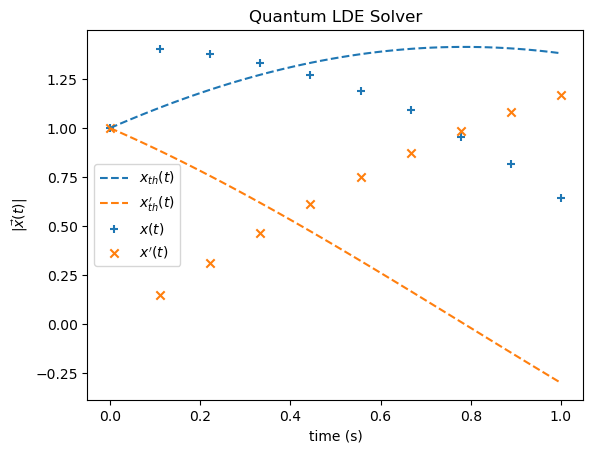

In [41]:
# moved to update the parse_data function
#yt = QuantumLDESolver(M, x0, b, k, err_bound).parse_data(results)
#yt = solver.data
import matplotlib.pyplot as plt
# use absolute value since we can only recover absolute amplitudes,
# no phase recovery!
def analytical_soln(w, times):
    # x, x'
    x_xdiv = [np.cos(w*times) + np.sin(w*times)/w, -w*np.sin(w*times) + np.cos(w*times)]
    return np.array(x_xdiv).T

smooth_times = np.linspace(times[0],times[-1],50)
plt.plot(smooth_times, analytical_soln(1, smooth_times), '--',label=['$x_{th}(t)$','$x_{th}\'(t)$'])
print(times.shape, yt.shape)
plt.scatter(times, yt[:,0], label='$x(t)$', marker='+')
plt.scatter(times, yt[:,1], label="$x'(t)$", marker='x')
plt.xlabel('time (s)')
plt.ylabel(r'$|\vec{x}(t)|$')
plt.title('Quantum LDE Solver')
plt.legend()

Now, let's print the results to make sure everything is working as intended!

In [ ]:
m = 1
#w = np.sqrt(k/m)
# m = k/w^2
k = m/(omega**2)
def KE(y):
    # kinetic energy = 1/2 m (y')^2
    return m* y[:,1]**2 /2

def PE(y):
    # 1/2 k y^2
    return k* y[:,0]**2 /2
